
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [3]:
import time
import math

import pandas as pd

from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *


Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'ETF'
imputation_method = 'Univariate'
ticker_str = 'SPY'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [4]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [5]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('2006-01-31 00:00:00')

In [6]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [7]:
# start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')
# 
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [8]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [9]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [10]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [11]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [12]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [13]:
def populate_kwargs(Strategy, env):
    # custom calculation here
    optimization_info = populateMVO(Strategy, env)
    addTurnoverConstraint(optimization_info, Strategy, env)
    addCardinalityConstraint(optimization_info, Strategy, env)
    optimization_info['period_Context'] = env.period_Context.rank()/(len(env.period_Context)+1)
    # get the rest
    for key, value in Strategy.investor_preferences.items():
        optimization_info[key] = value
    return optimization_info

def SVMMVO(limit_time=30, MipGap=0.01, **kwargs):  # if kwargs does not have limit time and mipgap then

    mu, targetRet, Q, K = kwargs['mu'], kwargs['targetRet'], kwargs['Q'], kwargs['K']
    q, epsilon, period_Context = kwargs['q'], kwargs['epsilon'], kwargs['period_Context']
    C, separable = kwargs['C'], kwargs['separable']
    bigMStrategy = kwargs['bigMStrategy']
    turnover_constraints = kwargs['turnover_constraints']
    previous_portfolio = kwargs['previous_portfolio']
    if turnover_constraints:
        turnover_limit = kwargs['turnover_limit']

    feasible_solution = True

    n, p = period_Context.shape
    mu = mu.squeeze()

    start = time.time()
    # compute big M here
    bigM, big_w, big_b, big_xi = bigMStrategy(**kwargs)
    
    print(bigM)

    bigM_finish_time = time.time()

    m, x_vars, z_vars, w_vars, b_var, t_vars, xi_vars = CreateSVMMVOModel(mu, targetRet, Q, K, q, epsilon,
                                                                          bigM, big_w,
                                                                          period_Context, C=C,
                                                                          separable=separable, limit_time=limit_time,
                                                                          MipGap=MipGap)

    if previous_portfolio is not None and turnover_constraints:  # add turnover constraints
        absolute_delta = addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit)

    m.optimize()  # try to solve
    # model did not solve
    if m.status in (4, 3):
        feasible_solution = False

        if previous_portfolio is not None and turnover_constraints:
            smallestTurnoverModelSVMMVO(m, n, absolute_delta, separable, w_vars, xi_vars, epsilon, C)

    obj_value, gap2, x, z, w, t, b, xi = extractSVMMVOSolution(n, p, m, x_vars, z_vars, w_vars, t_vars, b_var, xi_vars)

    end = time.time()
    return {'obj_value': obj_value, 'time': end - start, 'bigM_time': bigM_finish_time - start, 'optimality gap': gap2,
            'x': x, 'z': z, 'w': w, 't': t, 'b': b, 'xi': xi, 'feasible_solution': feasible_solution}





In [23]:
import math

import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time


# Cardinality Constrained Optimization
def CreateCardMVOModel(mu, targetRet, Q, K, limit_time=30, MipGap=0.01):
    n = len(mu)

    m = gp.Model("miqp")

    m.Params.timeLimit = limit_time

    m.Params.MIPGap = MipGap

    z_vars = m.addMVar(n, vtype=gp.GRB.BINARY, name="z_vars")

    x_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="x_vars")

    m.setObjective(x_vars @ Q @ x_vars, gp.GRB.MINIMIZE)

    m.addConstr(x_vars.sum() == 1)

    m.addConstr(mu @ x_vars >= targetRet)

    m.addConstr(z_vars.sum() <= K)

    m.addConstr(x_vars <= z_vars)

    return m, x_vars, z_vars


def extractSolution(n, m, x_vars, z_vars):
    x = np.zeros(n)
    z = np.zeros(n)
    for i in range(n):
        x[i] = x_vars[i].X
        z[i] = z_vars[i].X
    obj_value = m.objVal
    gap1 = m.MIPGap
    gap2 = gap1 * 100
    return obj_value, gap2, x, z


# def CardMVO(limit_time=30, MipGap=0.01, SolutionLimit=GRB.MAXINT, **kwargs):
#     mu, Q, K, targetRet = kwargs['mu'], kwargs['Q'], kwargs['K'], kwargs['targetRet']
#     n = len(mu)
#     mu = mu.squeeze()
#
#     start = time.time()
#
#     m, x_vars, z_vars = CreateCardMVOModel(mu, targetRet, Q, K, limit_time, MipGap)
#
#     m.SolutionLimit = SolutionLimit
#
#     m.optimize()
#     obj_value, gap2, x, z = extractSolution(n, m, x_vars, z_vars)
#
#     end = time.time()
#     return {'obj_value': obj_value, 'time': end - start, 'optimality gap': gap2, 'x': x, 'z': z}


def addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit):
    n = len(previous_portfolio)
    absolute_delta = m.addMVar(n, lb=-GRB.INFINITY, ub=GRB.INFINITY,
                               vtype=gp.GRB.CONTINUOUS, name="magntiude of portfolio changes")
    m.addConstr(absolute_delta >= x_vars - previous_portfolio)
    m.addConstr(absolute_delta >= previous_portfolio - x_vars)
    m.addConstr(absolute_delta.sum() <= turnover_limit, name='turnover')

    return absolute_delta


def smallestTurnoverModel(m, absolute_delta):
    # compute the smallest turnover portfolio instead of smallest risk with turnover constraints
    m.remove(m.getConstrByName('turnover'))
    m.reset()
    m.setObjective(absolute_delta.sum())
    m.optimize()


def CardMVO(limit_time=30, MipGap=0.01, SolutionLimit=GRB.MAXINT, **kwargs):
    mu, Q, K, targetRet = kwargs['mu'], kwargs['Q'], kwargs['K'], kwargs['targetRet']
    turnover_constraints = kwargs['turnover_constraints']
    previous_portfolio = kwargs['previous_portfolio']
    if turnover_constraints:
        turnover_limit = kwargs['turnover_limit']

    feasible_solution = True

    n = len(mu)
    mu = mu.squeeze()

    start = time.time()

    m, x_vars, z_vars = CreateCardMVOModel(mu, targetRet, Q, K, limit_time, MipGap)

    m.Params.SolutionLimit = SolutionLimit

    if previous_portfolio is not None and turnover_constraints:
        absolute_delta = addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit)

    m.optimize()

    # model did not solve
    if m.status in (4, 3):
        feasible_solution = False
        if previous_portfolio is not None and turnover_constraints:
            smallestTurnoverModel(m, absolute_delta)

    obj_value, gap2, x, z = extractSolution(n, m, x_vars, z_vars)

    end = time.time()

    return {'obj_value': obj_value, 'time': end - start,
            'optimality gap': gap2, 'x': x, 'z': z, 'feasible_solution': feasible_solution}


def CreateSVMMVOModel(mu, targetRet, Q, K, q, epsilon,
                      bigM, big_w,
                      period_Context, C, separable, limit_time, MipGap):
    n, p = period_Context.shape

    m = gp.Model("miqp")

    m.Params.timeLimit = limit_time

    m.Params.MIPGap = MipGap

    # binary variables
    z_vars = m.addMVar(n, vtype=gp.GRB.BINARY, name="z_vars")

    t_vars = m.addMVar(p, vtype=gp.GRB.BINARY, name="t_vars")

    x_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="x_vars")

    w_vars = m.addMVar(p, lb=-1 * GRB.INFINITY, ub=GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="w_vars")

    b_var = m.addMVar(shape=1, lb=-1 * GRB.INFINITY, name="b_var", vtype=gp.GRB.CONTINUOUS)

    m.addConstr(x_vars.sum() == 1)

    m.addConstr(mu @ x_vars >= targetRet)

    m.addConstr(z_vars.sum() <= K)

    m.addConstr(x_vars <= z_vars)

    if separable:
        xi_vars = None
        m.setObjective(x_vars @ Q @ x_vars + (epsilon / 2) * (w_vars @ w_vars), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr(w_vars @ y_i + b_var <= -1 + bigM * z_vars[i], name="svm1")
            m.addConstr(w_vars @ y_i + b_var >= 1 + bigM * (1 - z_vars[i]), name="svm2")
    else:
        xi_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="xi_vars")
        C_epsilon_by_n = C * epsilon / n
        m.setObjective(x_vars @ Q @ x_vars + (epsilon / 2) * (w_vars @ w_vars) + C_epsilon_by_n * xi_vars.sum(),
                       gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr(w_vars @ y_i + b_var <= -1 + xi_vars[i] + bigM * z_vars[i], name="svm1")
            m.addConstr(w_vars @ y_i + b_var >= 1 - xi_vars[i] - bigM * (1 - z_vars[i]), name="svm2")

    m.addConstr(w_vars <= big_w * t_vars)

    m.addConstr(w_vars >= -1 * big_w * t_vars)

    m.addConstr(t_vars.sum() <= q)

    return m, x_vars, z_vars, w_vars, b_var, t_vars, xi_vars


def corollary1(period_Context, q, big_w, big_xi):
    """
    """
    n, p = period_Context.shape
    largest_abs = 0
    pairs = period_Context.values - period_Context.values[:, None]
    pairs = np.abs(pairs)
    for i in range(n):
        for j in range(i):
            candidate = np.sort(pairs[i, j])[-1 * q:].sum()
            if candidate > largest_abs:
                largest_abs = candidate
    bigM = big_w * largest_abs + max(2, big_xi)

    return bigM


def corollary2(period_Context, big_w, big_xi):
    """
    """
    n, p = period_Context.shape
    largest_abs = 0
    pairs = period_Context.values - period_Context.values[:, None]
    pairs = np.abs(pairs)
    largest_abs = np.abs(pairs).sum(axis=-1).max()
    bigM = big_w * largest_abs + max(2, big_xi)

    return bigM


def corollary3(period_Context, q, big_w, big_b):
    """
    """
    n, p = period_Context.shape
    largest_abs = 0
    for i in range(n):
        candidate = period_Context.iloc[i].abs().sort_values(ascending=False).iloc[:q].sum()
        if candidate > largest_abs:
            largest_abs = candidate
    bigM = 1 + big_b + big_w * largest_abs

    return bigM


def corollary4(period_Context, big_w, big_b):
    """
    """
    bigM = 1 + big_b + big_w * period_Context.abs().sum(axis=1).max()
    return bigM


def CreateSVMModel(period_Context, z_vals, C, separable, limit_time):
    n, p = period_Context.shape

    m = gp.Model("miqp")

    m.Params.timeLimit = limit_time

    w_vars = m.addMVar(p, lb=-1 * GRB.INFINITY, ub=GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="w_vars")

    b_var = m.addMVar(shape=1, lb=-1 * GRB.INFINITY, name="b_var", vtype=gp.GRB.CONTINUOUS)

    if separable:
        xi_vars = None
        m.setObjective((1 / 2) * (w_vars @ w_vars), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr((2 * z_vals[i] - 1) * (y_i @ w_vars + b_var) >= 1)
    else:
        xi_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="xi_vars")
        C_by_n = C / n
        m.setObjective((1 / 2) * (w_vars @ w_vars) + C_by_n * xi_vars.sum(), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr((2 * z_vals[i] - 1) * (y_i @ w_vars + b_var) + xi_vars[i] >= 1)
    return m, w_vars, b_var, xi_vars


def extractSVMSolution(n, p, m, w_vars, b_var, xi_vars):
    w = np.zeros(p)
    b = np.zeros(1)
    xi = np.zeros(n)
    for i in range(p):
        w[i] = w_vars[i].X
    b[0] = b_var[0].X

    for i in range(n):
        if xi_vars is not None:
            xi[i] = xi_vars[i].X

    obj_value = m.objVal

    return obj_value, w, b, xi


def SVM(period_Context, z_vals, C, separable, limit_time):
    n, p = period_Context.shape

    start = time.time()

    m, w_vars, b_var, xi_vars = CreateSVMModel(period_Context, z_vals, C, separable, limit_time)

    m.optimize()

    obj_value, w, b, xi = extractSVMSolution(n, p, m, w_vars, b_var, xi_vars)

    end = time.time()
    return {'obj_value': obj_value, 'time': end - start, 'w': w, 'b': b, 'xi': xi}


# Big M strategies begin

def naivebigMStrategyCorollary3(**kwargs):
    """
    Follows Bianco et.al and assumes ||w, b|| \leq 1
    big_w = 1
    big_b = 1
    bigM = big_w + big_b +
    \max_{\mathcal{T} \subset [p]: |\mathcal{T}| \leq q} \max{i = 1...N} ||\boldsymbol{y}_{\mathcal{T}}^{(i)}||_1
    """
    period_Context, q = kwargs['period_Context'], kwargs['q']
    big_w = 1
    big_b = 1
    bigM = corollary3(period_Context, q, big_w, big_b)
    big_xi = None
    return bigM, big_w, big_b, big_xi


def naivebigMStrategyCorollary4(**kwargs):
    """
    Follows Bianco et.al and assumes ||w, b|| \leq 1
    big_w = 1
    big_b = 1
    bigM = big_w + big_b + \max{i = 1...N} ||\boldsymbol{y}^{(i)}||_1
    """
    period_Context = kwargs['period_Context']
    big_w = 1
    big_b = 1
    bigM = corollary4(period_Context, big_w, big_b)
    big_xi = None
    return bigM, big_w, big_b, big_xi


# def ConstructFeasibleSolution(mu, targetRet, Q, K, q, epsilon, period_Context, C, SolutionLimit,
#                               separable, limit_time=30, MipGap=0.01):
#     # card mvo
#     card_mvo_results = CardMVO(mu, Q, K, targetRet, limit_time=limit_time, MipGap=MipGap, SolutionLimit=SolutionLimit)
#     z_vals = card_mvo_results['z']
#     # SVM
#     svm_phase1_results = SVM(period_Context, z_vals, C, separable, limit_time)
#     # sort and clip w
#     w_vals = svm_phase1_results['w']
#     abs_w = np.abs(w_vals)
#     q_largest = np.argpartition(abs_w, (-1) * q)[-q:]
#     # restrict indices
#     period_Context_subset = period_Context.iloc[:, q_largest]
#     # SVM again
#     svm_phase2_results = SVM(period_Context_subset, z_vals, C, separable, limit_time)
#     # Calculate Objective Value
#     ObjSVM = svm_phase2_results['obj_value']
#     ObjMVO = card_mvo_results['obj_value']
#
#     return ObjMVO + epsilon * ObjSVM


def ConstructFeasibleSolution(bigM_limit_time=10, bigM_MipGap=0.1, bigM_SolutionLimit=10, **kwargs):
    period_Context, C, separable = kwargs['period_Context'], kwargs['C'], kwargs['separable']
    q, epsilon = kwargs['q'], kwargs['epsilon']

    # take out args into new dict

    bigM_kwargs_forCardMVO = kwargs.copy()
    bigM_kwargs_forCardMVO['limit_time'] = bigM_limit_time
    bigM_kwargs_forCardMVO['MipGap'] = bigM_MipGap
    bigM_kwargs_forCardMVO['SolutionLimit'] = bigM_SolutionLimit

    # card mvo
    card_mvo_results = CardMVO(**bigM_kwargs_forCardMVO)
    z_vals = card_mvo_results['z']
    # SVM
    svm_phase1_results = SVM(period_Context, z_vals, C, separable, bigM_limit_time)
    # sort and clip w
    w_vals = svm_phase1_results['w']
    abs_w = np.abs(w_vals)
    q_largest = np.argpartition(abs_w, (-1) * q)[-q:]
    # restrict indices
    period_Context_subset = period_Context.iloc[:, q_largest]
    # SVM again
    svm_phase2_results = SVM(period_Context_subset, z_vals, C, separable, bigM_limit_time)
    # Calculate Objective Value
    ObjSVM = svm_phase2_results['obj_value']
    ObjMVO = card_mvo_results['obj_value']

    return ObjMVO + epsilon * ObjSVM, card_mvo_results['feasible_solution']


def objectiveBigMStrategy(**kwargs):
    period_Context, epsilon, C, q = kwargs['period_Context'], kwargs['epsilon'], kwargs['C'], kwargs['q']

    ObjSVMMVO, feasible_solution = ConstructFeasibleSolution(
        **kwargs)  # kwargs may or may not have big M limit times etc

    n, p = period_Context.shape
    big_w = math.sqrt(ObjSVMMVO / epsilon)
    big_xi = n * ObjSVMMVO / (epsilon * C)
    bigM = corollary1(period_Context, q, big_w, big_xi)
    big_b = None
    return bigM, big_w, big_b, big_xi


def objectiveBigMStrategyTightening():
    # ObjSVM = ConstructFeasibleSolution()
    #
    # big_w = ObjSVM
    # big_xi = ObjSVM
    # bigM = corollary1()
    return None
    # min max big_b
    # update big_b
    # min max big xi with bound on b added
    # update big_xi
    # check using corrollary 3
    # update M
    # Solve SVMMVO using Gurobi?
    # update big_w, big_xi
    # bounds improved? Keep going


def extractSVMMVOSolution(n, p, m, x_vars, z_vars, w_vars, t_vars, b_var, xi_vars):
    x = np.zeros(n)
    z = np.zeros(n)
    w = np.zeros(p)
    t = np.zeros(p)
    b = np.zeros(1)
    xi = np.zeros(n)

    for i in range(n):
        x[i] = x_vars[i].X
        z[i] = z_vars[i].X
        if xi_vars is not None:
            xi[i] = xi_vars[i].X

    for i in range(p):
        w[i] = w_vars[i].X
        t[i] = t_vars[i].X
    b[0] = b_var[0].X

    obj_value = m.objVal
    gap1 = m.MIPGap
    gap2 = gap1 * 100
    return obj_value, gap2, x, z, w, t, b, xi



def smallestTurnoverModelSVMMVO(m, n, absolute_delta, separable, w_vars, xi_vars, epsilon, C):
    # compute the smallest turnover portfolio instead of smallest risk with turnover constraints

    m.remove(m.getConstrByName('turnover'))
    m.reset()

    if separable:
        m.setObjective(absolute_delta.sum() + (epsilon / 2) * (w_vars @ w_vars), gp.GRB.MINIMIZE)
    else:
        C_epsilon_by_n = C * epsilon / n
        m.setObjective(absolute_delta.sum() + (epsilon / 2) * (w_vars @ w_vars) + C_epsilon_by_n * xi_vars.sum(),
                       gp.GRB.MINIMIZE)

    m.optimize()


def SVMMVO(limit_time=30, MipGap=0.01, **kwargs):  # if kwargs does not have limit time and mipgap then

    mu, targetRet, Q, K = kwargs['mu'], kwargs['targetRet'], kwargs['Q'], kwargs['K']
    q, epsilon, period_Context = kwargs['q'], kwargs['epsilon'], kwargs['period_Context']
    C, separable = kwargs['C'], kwargs['separable']
    bigMStrategy = kwargs['bigMStrategy']
    turnover_constraints = kwargs['turnover_constraints']
    previous_portfolio = kwargs['previous_portfolio']
    if turnover_constraints:
        turnover_limit = kwargs['turnover_limit']

    feasible_solution = True

    n, p = period_Context.shape
    mu = mu.squeeze()

    start = time.time()
    # compute big M here
    bigM, big_w, big_b, big_xi = bigMStrategy(**kwargs)
    print("Big M ", bigM)
    print("big W", big_w)
    print("big xi", big_xi)
    
    bigM_finish_time = time.time()

    m, x_vars, z_vars, w_vars, b_var, t_vars, xi_vars = CreateSVMMVOModel(mu, targetRet, Q, K, q, epsilon,
                                                                          bigM, big_w,
                                                                          period_Context, C=C,
                                                                          separable=separable, limit_time=limit_time,
                                                                          MipGap=MipGap)

    if previous_portfolio is not None and turnover_constraints:  # add turnover constraints
        absolute_delta = addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit)

    m.optimize()  # try to solve
    # model did not solve
    if m.status in (4, 3):
        feasible_solution = False

        if previous_portfolio is not None and turnover_constraints:
            smallestTurnoverModelSVMMVO(m, n, absolute_delta, separable, w_vars, xi_vars, epsilon, C)

    obj_value, gap2, x, z, w, t, b, xi = extractSVMMVOSolution(n, p, m, x_vars, z_vars, w_vars, t_vars, b_var, xi_vars)
    print("Objective Value", obj_value)
    print("w norm ", w)
    print("Classification errors ", np.sum(xi))
    end = time.time()
    return {'obj_value': obj_value, 'time': end - start, 'bigM_time': bigM_finish_time - start, 'optimality gap': gap2,
            'x': x, 'z': z, 'w': w, 't': t, 'b': b, 'xi': xi, 'feasible_solution': feasible_solution}


In [29]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest)
k = 6*20 #estimation
alpha= 1 - 0.985 #estimation
return_premium = 1.7 #optimization

turnover_constraints = False
turnover_limit = 1 # 0.75, 1, 1.25
cardinality_ratio = 0.05 #optimization

MipGap = 0.05
limit_time = 30

target_return_strategy = ticker_return_target
target_return_strategy_args = ['ticker_index']

bigMStrategy = objectiveBigMStrategy
bigM_limit_time=10
bigM_MipGap=0.1
bigM_SolutionLimit=10

ticker_index = tickers.get_loc(ticker_str)

q = 2
C = 1
epsilon = 1
separable = False

investor_preferences = {'k':k, # horizon
                        'alpha':alpha, #decay 
                        'premium':return_premium, #return premium preference
                        'ticker_index':ticker_index, #benchmark index for comparison used in place of return premium depending on the investors function to set r_min 
                        'target_return_strategy':target_return_strategy, #strategy for setting return
                        'target_return_strategy_args': target_return_strategy_args, #args for return setting strategy 
                        
                        'turnover_limit':turnover_limit, #turnover limit
                        'turnover_constraints':turnover_constraints, #turnover limit choice (Y/N)
                        'cardinality_ratio': cardinality_ratio, #Pct of assets to invest in
                        'MipGap' : MipGap, 'limit_time':limit_time, #problem solving limits
    
                        'bigMStrategy':bigMStrategy,
                        'bigM_limit_time':bigM_limit_time,
                        'bigM_MipGap':bigM_MipGap,
                        'bigM_SolutionLimit':bigM_SolutionLimit,
                        
                        'q':q,
                        'C':C,
                        'epsilon':epsilon,
                        'separable':separable}

Strategy = general_strategy(exponential_weighted_estimator, SVMMVO,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator
# 
Strategy.extract_optimization_info = populate_kwargs

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [30]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

#End of the first investment period
#testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [31]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 2008-06-30 00:00:00
Test End 2008-11-30 00:00:00
Calibration End 2008-06-29 00:00:00


In [32]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

In [33]:
# Number of assets
n  = len(tickers)
env.n = n

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    #take the last available contextual observations
    period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
    period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
    period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

    env.periodReturns = periodReturns
    env.periodFactRet = periodFactRet
    env.period_daily_adjClose = period_daily_adjClose
    env.period_Context = period_Context
    #there should be a feature vector for each asset
    assert len(period_Context) == n
    #all the tickers should be aligned in the context and ticker dataset 
    assert (periodReturns.columns == period_Context.index).all()

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]
            #update the previous periods portfolio 
        env.previous_portfolio = x0[:,t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    # add in the estimation info

    x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);
    
    #Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)
    

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

Set parameter TimeLimit to value 10
Set parameter MIPGap to value 0.1
Set parameter SolutionLimit to value 10
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 302 rows, 598 columns and 1495 nonzeros
Model fingerprint: 0x6b08e074
Model has 44850 quadratic objective terms
Variable types: 299 continuous, 299 integer (299 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-06, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+01]
Found heuristic solution: objective 0.0157912
Presolve time: 0.01s
Presolved: 302 rows, 598 columns, 1495 nonzeros
Presolved model has 44850 quadratic objective terms
Variable types: 299 continuous, 299 integer (299 binary)

Root relaxation: objective 4.122709e

# 3. Results

In [34]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
Ret = 12*((portfExRets + 1).apply(gmean, axis=0) - 1)
Vol = (12**0.5)*(portfExRets.std())
SR = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std())

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Annualized return: ', str(Ret[0]))
print('Annualized vol: ', str(Vol[0]))
print('Annualized Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))

Elasped time is 493.29339718818665 seconds
Annualized return:  0.08448084645872633
Annualized vol:  0.1069643925194485
Annualized Sharpe ratio:  0.7898034520540639
Avg. turnover:  1.950127398007742


### Observations

        The end to end strategy has the following stats when we use 15 observations:
        Elasped time is 27.749337434768677 seconds
        Sharpe ratio:  0.36926056542515073
        Avg. turnover:  0.2846570354951544

        Standard MVO has the following stats when we use 15 observations::
        
        Elasped time is 1.1906468868255615 seconds
        Sharpe ratio:  0.35584233976844887
        Avg. turnover:  0.6967647038270909

        The end to end strategy has the following stats when we use 35 observations:
        
        Elasped time is 16.95100688934326 seconds
        Sharpe ratio:  0.33129478714103455
        Avg. turnover:  0.13229814142751284

        Standard MVO has the following stats when we use 35 observations:
        
        Elasped time is 1.2436742782592773 seconds
        Sharpe ratio:  0.2997765726515852
        Avg. turnover:  0.25328429647155937


In [35]:
value_target_index = initialVal*(1 + adjClose.pct_change(1).loc[portfValue.index, ticker_str]).cumprod()
portfValue[ticker_str] = value_target_index
portfValue.columns = ['Strategy', ticker_str]

<Figure size 640x480 with 0 Axes>

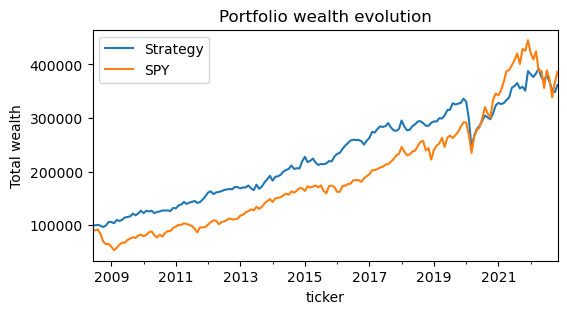

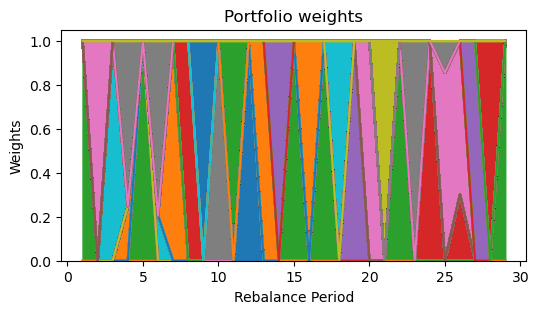

In [36]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.iloc[:,:].plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = True)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
if n <= 20:
    legend_bool = True
else:
    legend_bool = False
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = legend_bool, stacked = True)
if legend_bool:
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%

In [37]:
weights.iloc[:,-1][weights.iloc[:,-1] > 0.001]

AGG    1.0
Name: 29, dtype: float64

In [38]:
(np.abs(daily_adjClose.diff().dropna()) <= 0.001).sum().sort_values()

IWM      9
IJH     10
MDY     10
VBK     11
SPY     12
      ... 
DHF    696
CIF    704
BHV    710
MIN    710
NOM    823
Length: 299, dtype: int64

In [39]:
# Calculate the portfolio Sharpe ratio
ticker_rets = adjClose.pct_change(1).iloc[1:,]
ticker_rets = ticker_rets.loc[portfRets.index]

tickerExRets = ticker_rets.subtract(riskFree[(riskFree.index >= ticker_rets.index[0])&(riskFree.index <= ticker_rets.index[-1])], axis = 0)

tickerSR = ((tickerExRets + 1).apply(gmean, axis=0) - 1)/tickerExRets.std()

In [44]:
(12**0.5)*tickerSR.sort_values(ascending=False)

XLV    0.804764
VHT    0.794131
IYH    0.787849
VDC    0.778656
IYK    0.756460
         ...   
ILF   -0.088014
EWZ   -0.118883
ASA   -0.119508
OIH   -0.236428
CEE   -0.309959
Length: 299, dtype: float64

In [46]:
(12**0.5)*tickerSR[ticker_str]

0.5872509277658715